# INTRODUCTION
In this notebook, we train and evaluate a Multinomial Naive Bayes classifier to distinguish between NBC and FoxNews headlines. Given the short, keyword-heavy nature of headlines, Naive Bayes is a fast and effective model for this task.

We explore different vectorization techniques and tune the `alpha` smoothing parameter using GridSearchCV.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, RocCurveDisplay
import warnings
warnings.filterwarnings('ignore')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
news_df = pd.read_csv("/content/drive/My Drive/CIS5190_project/scraped_headlines.csv")
news_df.dropna(subset=['title'], inplace=True)
news_df.drop(columns=['url'], inplace=True)  # Drop url column (not used)

In [5]:
with open("/content/drive/My Drive/CIS5190_project/custom_stopwords.txt", "r") as f:
    custom_stopwords = [line.strip() for line in f.readlines()]

#PREPROCESSING

We preprocess the headlines using:
- Lowercasing
- Stopword removal (both NLTK and custom branding-related terms)
- No lemmatization or stemming (not useful for distinguishing outlet framing)

In [6]:
# Clean and preprocess headlines
news_df['clean_title'] = news_df['title'].str.lower()
X = news_df['clean_title']
y = news_df['label']  # 1 for FoxNews, 0 for NBC

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


# Vectorization Strategies
We compare three vectorization approaches:

- **TF-IDF (Unigram + Bigram)**: Captures importance of rare editorial phrases.
- **CountVectorizer (Unigram)**: Simple frequency-based representation.
- **HashingVectorizer**: Memory-efficient, but lacks interpretability.

All vectorizers are tested with consistent preprocessing and feature sizes (e.g., `max_features = 5000`)

In [8]:
vectorizers = {
    "TF-IDF": TfidfVectorizer(stop_words=custom_stopwords),
    "Count": CountVectorizer(stop_words=custom_stopwords),
    "Hashing": HashingVectorizer(stop_words='english', n_features=5000, alternate_sign=False)
}

In [9]:
# Define Naive Bayes classifier
nb = MultinomialNB()

In [10]:
results = {}


# Grid Search and HyperParameter Tuning

We use GridSearchCV with 3-fold cross-validation to tune the `alpha` smoothing parameter for Naive Bayes. This helps avoid overfitting in sparse feature spaces. k=3 is enough for dataset size 5000, for model exploration. For the best model, we can later run with k=5 or 10


===== Running GridSearch for TF-IDF Vectorizer =====
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Params for TF-IDF: {'nb__alpha': 1.0, 'vectorizer__max_features': 5000, 'vectorizer__ngram_range': (1, 2)}
Test Accuracy: 0.7729
ROC AUC: 0.8541

              precision    recall  f1-score   support

           0       0.77      0.78      0.77       495
           1       0.78      0.76      0.77       500

    accuracy                           0.77       995
   macro avg       0.77      0.77      0.77       995
weighted avg       0.77      0.77      0.77       995



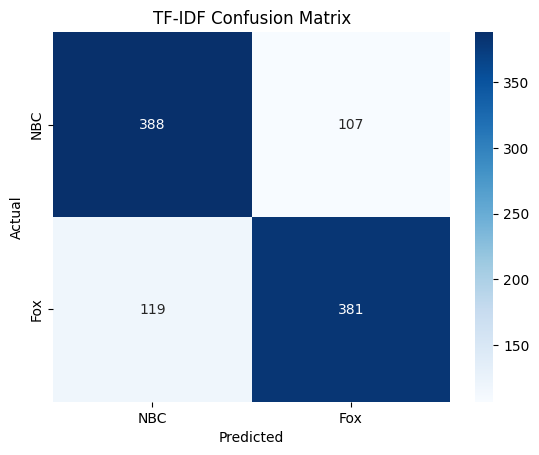

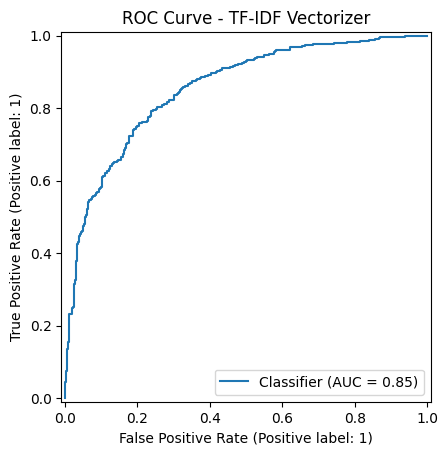


Top tokens for NBC:
trump: -5.3082
says: -5.8323
best: -5.8525
israel: -5.9481
gaza: -6.1262
jan: -6.2634
new: -6.2860
according: -6.3352
election: -6.3851
biden: -6.3952
hamas: -6.4030
harris: -6.4386
israeli: -6.4879
experts: -6.6146
say: -6.6711

Top tokens for FoxNews:
trump: -5.4659
harris: -5.5136
biden: -5.6818
says: -5.9763
us: -6.2398
kamala: -6.2828
kamala harris: -6.3580
new: -6.3586
day: -6.4332
american: -6.5359
history: -6.5853
israel: -6.5915
house: -6.6154
state: -6.6605
debate: -6.7199

===== Running GridSearch for Count Vectorizer =====
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Params for Count: {'nb__alpha': 1.0, 'vectorizer__max_features': 5000, 'vectorizer__ngram_range': (1, 2)}
Test Accuracy: 0.7749
ROC AUC: 0.8562

              precision    recall  f1-score   support

           0       0.77      0.79      0.78       495
           1       0.79      0.76      0.77       500

    accuracy                           0.77       995
   macro 

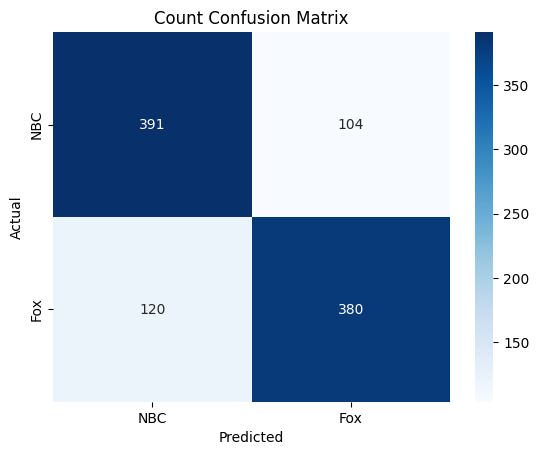

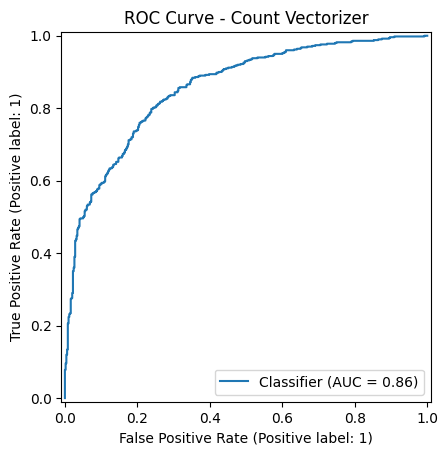


Top tokens for NBC:
trump: -4.1131
says: -4.8675
israel: -5.1591
best: -5.2308
gaza: -5.4519
biden: -5.4727
new: -5.4833
harris: -5.5493
jan: -5.6199
election: -5.6828
hamas: -5.7639
israeli: -5.8522
according: -5.9322
say: -6.0012
court: -6.0563

Top tokens for FoxNews:
trump: -4.2767
harris: -4.5479
biden: -4.7520
says: -5.0210
new: -5.5759
us: -5.6312
kamala: -5.6542
kamala harris: -5.7518
israel: -5.8045
day: -5.8181
american: -5.9977
house: -6.0142
history: -6.0310
state: -6.0481
first: -6.2167

===== Running GridSearch for Hashing Vectorizer =====
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best Params for Hashing: {'nb__alpha': 1.0}
Test Accuracy: 0.7367
ROC AUC: 0.8165

              precision    recall  f1-score   support

           0       0.73      0.74      0.74       495
           1       0.74      0.73      0.74       500

    accuracy                           0.74       995
   macro avg       0.74      0.74      0.74       995
weighted avg       0.74  

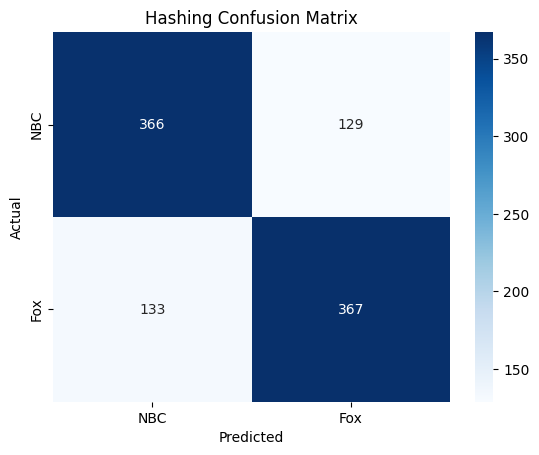

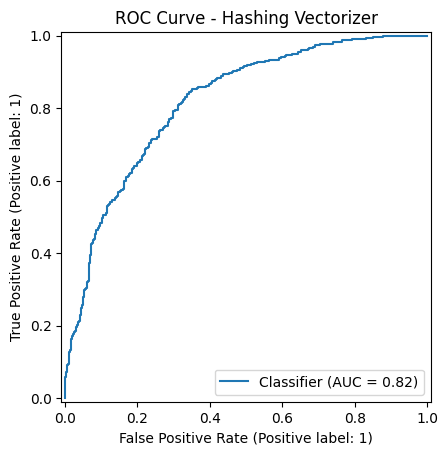

Feature importance not available for HashingVectorizer


In [11]:
for name, vectorizer in vectorizers.items():
    print(f"\n===== Running GridSearch for {name} Vectorizer =====")

    pipeline = Pipeline([
        ('vectorizer', vectorizer),
        ('nb', nb)
    ])

    if name in ["TF-IDF", "Count"]:
        param_grid = {
            'vectorizer__max_features': [3000, 5000],
            'vectorizer__ngram_range': [(1, 1), (1, 2)],
            'nb__alpha': [0.1, 1.0, 5.0]
        }
    elif name == "Hashing":
        param_grid = {
            'nb__alpha': [0.1, 1.0, 5.0]
        }

    grid = GridSearchCV(pipeline, param_grid, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)
    grid.fit(X_train, y_train)

    y_pred = grid.predict(X_test)
    y_proba = grid.predict_proba(X_test)[:, 1]

    print(f"Best Params for {name}: {grid.best_params_}")
    print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}\n")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['NBC', 'Fox'], yticklabels=['NBC', 'Fox'])
    plt.title(f'{name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    RocCurveDisplay.from_predictions(y_test, y_proba)
    plt.title(f'ROC Curve - {name} Vectorizer')
    plt.show()

    vec = grid.best_estimator_.named_steps['vectorizer']
    clf = grid.best_estimator_.named_steps['nb']

    if hasattr(vec, 'get_feature_names_out'):
        feature_names = vec.get_feature_names_out()
        log_probs = clf.feature_log_prob_

        top_n = 15
        for i, label in enumerate(["NBC", "FoxNews"]):
            top_tokens = np.argsort(log_probs[i])[-top_n:]
            print(f"\nTop tokens for {label}:")
            for idx in reversed(top_tokens):
                print(f"{feature_names[idx]}: {log_probs[i][idx]:.4f}")
    else:
        print(f"Feature importance not available for {type(vec).__name__}")



    results[name] = {
        'model': grid.best_estimator_,
        'accuracy': accuracy_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_proba),
        'params': grid.best_params_
    }


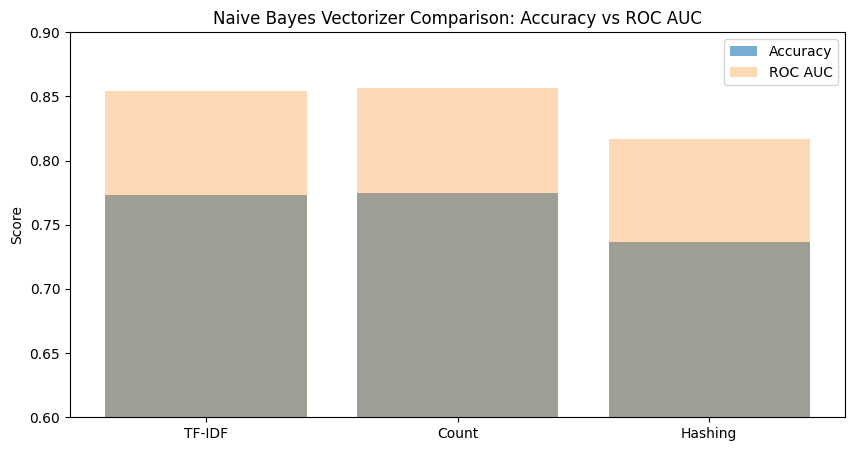

In [12]:
accs = [results[v]['accuracy'] for v in results]
rocs = [results[v]['roc_auc'] for v in results]
labels = list(results.keys())

plt.figure(figsize=(10,5))
plt.bar(labels, accs, alpha=0.6, label='Accuracy')
plt.bar(labels, rocs, alpha=0.3, label='ROC AUC')
plt.title("Naive Bayes Vectorizer Comparison: Accuracy vs ROC AUC")
plt.ylabel("Score")
plt.legend()
plt.ylim(0.6, 0.9)
plt.show()

# Results Summary and Inferences

TF-IDF with bigrams CountVectorizer with bigrams both got almost identical accuracy and much better compared to Hashing. Naive Bayes achieved:

- Accuracy: ~77%
- ROC AUC: ~0.86
- Strong interpretability as top keywords aligned with framing differences


Having said that, from ML theory, we know that, one major limitation is Naive Bayes assumes feature independence, which may not hold in phrased headlines.

# Generating Predictions and Exporting Best Model

In [29]:
import joblib
joblib.dump(grid.best_estimator_, '/content/drive/My Drive/CIS5190_project/naive_best_model.pkl')

['/content/drive/My Drive/CIS5190_project/naive_best_model.pkl']

In [20]:
unseen_df = pd.read_csv("/content/drive/My Drive/CIS5190_project/News Classification_Test Data_Project.csv")

In [21]:
unseen_df.head()

,ID,Headline,Label(FoxNews/NBC)
0,1,Democrats' boiling pot: A look at their 2026 g...,NaN
1,2,Appeals court restores hold on Trump admin’s p...,NaN
2,3,"David Perdue, former senator and longtime Trum...",NaN
3,4,Tesla arson suspect arrested in Arizona after ...,NaN
4,5,Trump wants Eagles' tush push to remain in NFL...,NaN


In [30]:
model = joblib.load("/content/drive/My Drive/CIS5190_project/naive_best_model.pkl")

In [23]:
X_unseen = (
    unseen_df["Headline"]
      .str.strip()
      .str.lower()
)

In [25]:
preds_num = model.predict(X_unseen)

unseen_df['Label(FoxNews/NBC)'] = ["FoxNews" if p == 1 else "NBC" for p in preds_num]

In [26]:
counts = unseen_df["Label(FoxNews/NBC)"].value_counts()
print(counts)

Label(FoxNews/NBC)
NBC        588
FoxNews    585
Name: count, dtype: int64


In [31]:
unseen_df.to_csv("/content/drive/My Drive/CIS5190_project/predictions/NaiveBayesPredictions.csv", index=False)